In [620]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import mstats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [621]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix, classification_report

In [622]:
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [623]:
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [624]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [625]:
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [626]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [627]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not
# Consider aggregating this table at a customer level (e.g., you could aggregate based on number of campaigns they responded YES to, or the most common campaign they responded to, etc.)
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [628]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [629]:
# you will use this table to calculate LTV. Hint: you should SUM all transaction amounts PER customer, to calculate total LTV
# you can use the other features (like last transaction date) to calculate their customer age (e.g., time between join date and last transaction date)
# you could also consider feature engineering a favourite category for example
# consider using RFM framework to assess the recency, frequency, or monetary value of transactions to create segments
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [630]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [631]:
marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [632]:
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [633]:
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [634]:
joint_data = customers.join(engagement).join(transactions_agg).join(marketing_agg)

In [635]:
joint_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   join_date                10000 non-null  object 
 1   last_purchase_date       10000 non-null  object 
 2   age                      8991 non-null   float64
 3   gender                   9467 non-null   object 
 4   location                 10000 non-null  object 
 5   number_of_site_visits    10000 non-null  int64  
 6   number_of_emails_opened  10000 non-null  int64  
 7   number_of_clicks         10000 non-null  int64  
 8   transaction_id           10000 non-null  int64  
 9   transaction_amount       10000 non-null  float64
 10  campaign_id              7665 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 937.5+ KB


In [636]:
# Handle missing values
joint_data['age'].fillna(joint_data['age'].median(), inplace=True)
joint_data['gender'].fillna('Unknown', inplace=True)
joint_data['location'].fillna('Unknown', inplace=True)
joint_data['last_purchase_date'].fillna(joint_data['join_date'], inplace=True)
joint_data.fillna(0, inplace=True)

/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_3860/310510056.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joint_data['age'].fillna(joint_data['age'].median(), inplace=True)
/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_3860/310510056.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [637]:
nan_check = joint_data.isnull().sum()
print(nan_check)

join_date                  0
last_purchase_date         0
age                        0
gender                     0
location                   0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
transaction_id             0
transaction_amount         0
campaign_id                0
dtype: int64


In [638]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,44.0,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,44.0,Unknown,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,161,2,7,24,15524.55,0.0


In [639]:
joint_data['join_date'] = pd.to_datetime(joint_data['join_date'])
joint_data['last_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'])

In [640]:
# Calculate Recency: days since the last purchase
current_date = datetime.now()
joint_data['recency'] = (current_date - joint_data['last_purchase_date']).dt.days


In [641]:
# Calculate Frequency: number of purchases
joint_data['frequency'] = joint_data['transaction_id']

In [642]:
# Calculate Monetary: total spend
joint_data['monetary'] = joint_data['transaction_amount']

In [643]:
# Calculate Customer Age (time since joining)
joint_data['join_date'] = pd.to_datetime(joint_data['join_date'])
joint_data['customer_age'] = (current_date - joint_data['join_date']).dt.days

In [644]:
# Calculate Average Transaction Amount
joint_data['avg_transaction_amount'] = joint_data['monetary'] / joint_data['frequency']

In [645]:
# Calculate Engagement Level
joint_data['engagement_level'] = joint_data[['number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks']].sum(axis=1)

In [646]:
# Create interaction features
joint_data['recency_customer_age_ratio'] = joint_data['recency'] / joint_data['customer_age']
joint_data['avg_spend_per_visit'] = joint_data['monetary'] / joint_data['number_of_site_visits']

In [647]:
# Assuming a customer lifespan of 1 year for simplification (this should be adjusted based on business knowledge)
joint_data['customer_lifespan'] = joint_data['customer_age'].mean()/30

# Calculate CLV using the provided formula
joint_data['clv'] = joint_data['avg_transaction_amount'] * joint_data['frequency'] * joint_data['customer_lifespan']

In [648]:
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,recency,frequency,monetary,customer_age,avg_transaction_amount,engagement_level,recency_customer_age_ratio,avg_spend_per_visit,customer_lifespan,clv
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,...,122,6,3509.48,240,584.913333,26,0.508333,350.948000,28.353513,99506.087973
2,2021-09-08,2023-10-25,44.0,Male,Hillville,285,49,51,9,6081.32,...,266,9,6081.32,1043,675.702222,385,0.255034,21.337965,28.353513,172426.787704
3,2021-06-01,2022-11-27,44.0,Unknown,North Latoyatown,192,73,25,6,1454.87,...,598,6,1454.87,1142,242.478333,290,0.523643,7.577448,28.353513,41250.675943
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,...,685,20,7874.68,928,393.734000,157,0.738147,71.588000,28.353513,223274.844376
5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,161,2,7,24,15524.55,...,411,24,15524.55,905,646.856250,170,0.454144,96.425776,28.353513,440175.535419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,...,339,10,5498.20,579,549.820000,182,0.585492,46.203361,28.353513,155893.287009
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,...,539,12,5848.30,739,487.358333,50,0.729364,1949.433333,28.353513,165819.852027
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,...,169,3,3503.13,304,1167.710000,75,0.555921,66.096792,28.353513,99326.043163


In [649]:
joint_data['gender'] = joint_data['gender'].replace({'Male': -1, 'Female': 1, 'Unknown': 0})

/var/folders/ft/gq7wv6zs1slgbv35cnp736j00000gp/T/ipykernel_3860/121067543.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  joint_data['gender'] = joint_data['gender'].replace({'Male': -1, 'Female': 1, 'Unknown': 0})


In [650]:
# Drop columns that are not needed anymore
joint_data.drop(columns=['transaction_id', 'transaction_amount', 'last_purchase_date', 'join_date', 'location'], inplace=True)

In [651]:
clv_threshold = joint_data['clv'].median()
joint_data['high_value_customer'] = (joint_data['clv'] > clv_threshold).astype(int)

In [652]:
X= joint_data[['number_of_clicks','age', 'number_of_emails_opened','avg_transaction_amount', 'recency','gender','customer_age','engagement_level', 'frequency']]
y= joint_data['high_value_customer']

In [653]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [654]:
# Display the shapes of the train and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (8000, 9)
Test set shape: (2000, 9)


In [655]:
# Train a Logistic Regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [656]:
# Predict on the test set
y_pred_logistic = logistic_reg.predict(X_test)

In [657]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_logistic)
precision = precision_score(y_test, y_pred_logistic)
recall = recall_score(y_test, y_pred_logistic)
f1 = f1_score(y_test, y_pred_logistic)
conf_matrix = confusion_matrix(y_test, y_pred_logistic)
print(f'Logistic Regression - Accuracy: {accuracy}')
print(f'Logistic Regression - Precision: {precision}')
print(f'Logistic Regression - Recall: {recall}')
print(f'Logistic Regression - F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Logistic Regression - Accuracy: 0.8535
Logistic Regression - Precision: 0.8346080305927343
Logistic Regression - Recall: 0.879154078549849
Logistic Regression - F1 Score: 0.8563021088769004
Confusion Matrix:
[[834 173]
 [120 873]]


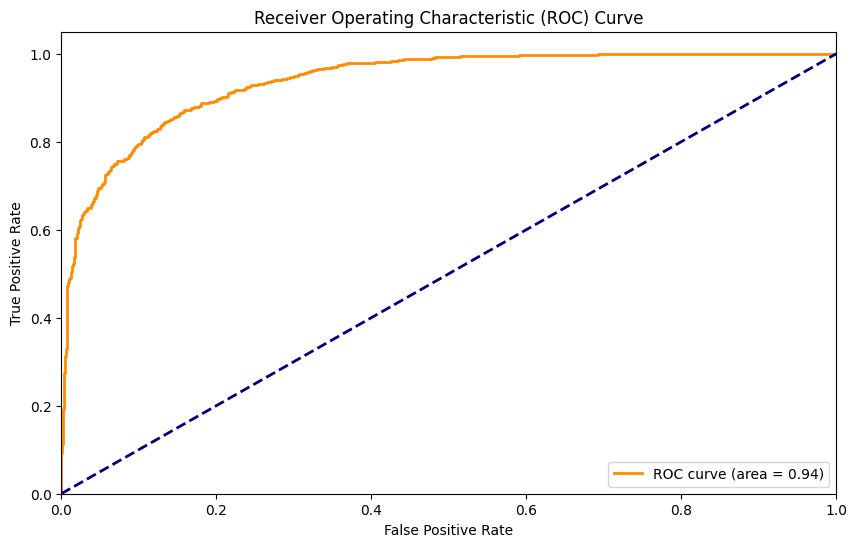

In [658]:
# Predict the probabilities for the positive class
y_prob_logistic = logistic_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob_logistic)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [659]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1007
           1       0.83      0.88      0.86       993

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



In [660]:
# Train a Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)


LinearRegression()

In [661]:
# Predict on the test set
y_pred_linear = linear_reg.predict(X_test)


<Axes: >

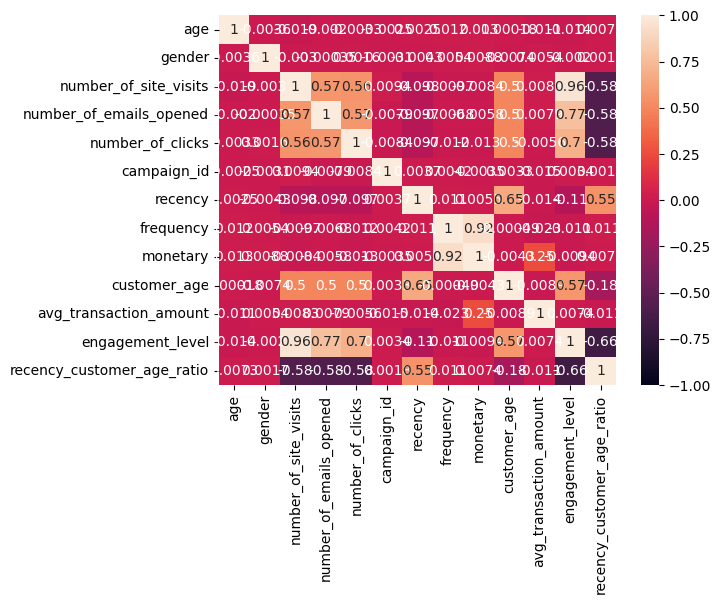

In [662]:
sns.heatmap(joint_data.iloc[:,:13].corr(), annot=True, vmin=-1, vmax=1)

In [663]:
# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(mae_linear)
print(mse_linear)
print(r2_linear)

0.23086820637725777
0.07739168233817288
0.690418101134264


In [664]:
# Create a DataFrame with actual vs predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_linear, 'Residual': y_test - y_pred_linear})

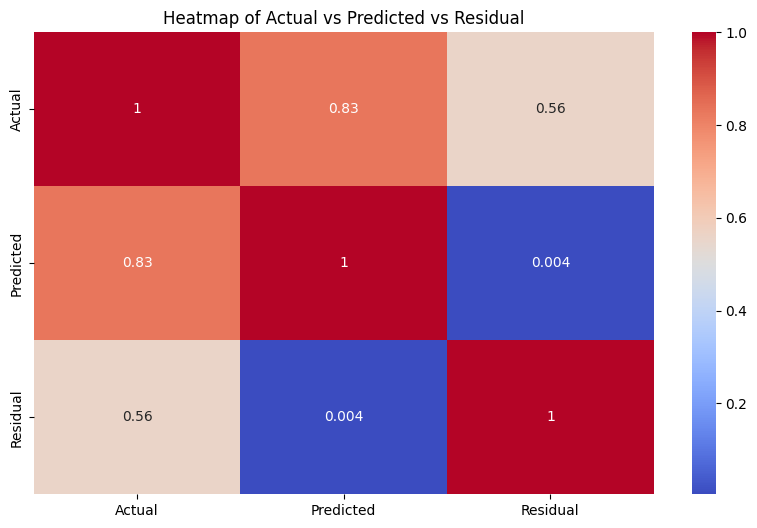

In [665]:
# Plot the residuals heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results[['Actual', 'Predicted', 'Residual']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Actual vs Predicted vs Residual')
plt.show()

In [666]:
# Train a KNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [667]:
# Predict on the test set
y_pred_knn = knn_classifier.predict(X_test)


In [668]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
print(f'KNN Classifier - Accuracy: {accuracy}')
print(f'KNN Classifier - Precision: {precision}')
print(f'KNN Classifier - Recall: {recall}')
print(f'KNN Classifier - F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

KNN Classifier - Accuracy: 0.6275
KNN Classifier - Precision: 0.6085814360770578
KNN Classifier - Recall: 0.6998992950654582
KNN Classifier - F1 Score: 0.6510538641686182
Confusion Matrix:
[[560 447]
 [298 695]]


In [669]:
# Predict the probabilities for the positive class
y_prob_knn = knn_classifier.predict_proba(X_test)[:, 1]

In [670]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
roc_auc = auc(fpr, tpr)

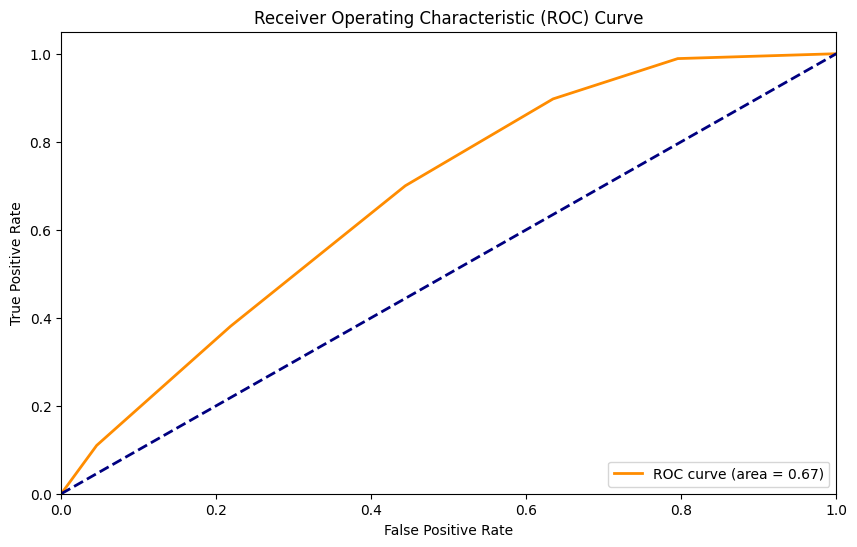

In [671]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [672]:
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1007
           1       0.61      0.70      0.65       993

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000

